In [3]:
# Intstall PyTorch and download data
!pip3 install torch torchvision

!wget -c http://ufldl.stanford.edu/housenumbers/train_32x32.mat http://ufldl.stanford.edu/housenumbers/test_32x32.mat

--2019-12-22 14:11:19--  http://ufldl.stanford.edu/housenumbers/train_32x32.mat
Resolving ufldl.stanford.edu (ufldl.stanford.edu)... 171.64.68.10
Connecting to ufldl.stanford.edu (ufldl.stanford.edu)|171.64.68.10|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 182040794 (174M) [text/plain]
Saving to: ‘train_32x32.mat’

train_32x32.mat     100%[===================>] 173.61M  94.3MB/s    in 1.8s    

2019-12-22 14:11:21 (94.3 MB/s) - ‘train_32x32.mat’ saved [182040794/182040794]

--2019-12-22 14:11:21--  http://ufldl.stanford.edu/housenumbers/test_32x32.mat
Reusing existing connection to ufldl.stanford.edu:80.
HTTP request sent, awaiting response... 200 OK
Length: 64275384 (61M) [text/plain]
Saving to: ‘test_32x32.mat’

test_32x32.mat      100%[===================>]  61.30M   108MB/s    in 0.6s    

2019-12-22 14:11:22 (108 MB/s) - ‘test_32x32.mat’ saved [64275384/64275384]

FINISHED --2019-12-22 14:11:22--
Total wall clock time: 2.5s
Downloaded: 2 files, 235M in

In [4]:
!ls

sample_data  test_32x32.mat  train_32x32.mat


In [5]:
!nvidia-smi

Sun Dec 22 14:11:55 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.44       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P8     7W /  75W |      0MiB /  7611MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [0]:
from collections import namedtuple

import matplotlib.pyplot as plt
import numpy as np
import PIL
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.datasets as dset
from torch.utils.data.sampler import SubsetRandomSampler

from torchvision import transforms

In [0]:
device = torch.device("cuda:0") # Let's make sure GPU is available!

In [0]:
# First, lets load the dataset
data_train = dset.SVHN('./', 
                       transform=transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize(mean=[0.43,0.44,0.47],
                                               std=[0.20,0.20,0.20])                           
                       ])
                      )
data_test = dset.SVHN('./', split='test', transform=transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize(mean=[0.43,0.44,0.47],
                                               std=[0.20,0.20,0.20])                           
                       ]))

In [0]:
batch_size = 64

data_size = data_train.data.shape[0]
validation_split = .2
split = int(np.floor(validation_split * data_size))
indices = list(range(data_size))
np.random.shuffle(indices)

train_indices, val_indices = indices[split:], indices[:split]

train_sampler = SubsetRandomSampler(train_indices)
val_sampler = SubsetRandomSampler(val_indices)

train_loader = torch.utils.data.DataLoader(data_train, batch_size=batch_size, 
                                           sampler=train_sampler)
val_loader = torch.utils.data.DataLoader(data_train, batch_size=batch_size,
                                         sampler=val_sampler)

In [0]:
# We'll use a special helper module to shape it into a flat tensor
class Flattener(nn.Module):
    def forward(self, x):
        batch_size, *_ = x.shape
        return x.view(batch_size, -1)

In [0]:
nn_model = nn.Sequential(
            nn.Conv2d(3, 64, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(4),
            nn.Conv2d(64, 64, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(4),    
            Flattener(),
            nn.Linear(64*2*2, 10),
          )

nn_model.type(torch.cuda.FloatTensor)
nn_model.to(device)

loss = nn.CrossEntropyLoss().type(torch.cuda.FloatTensor)
optimizer = optim.SGD(nn_model.parameters(), lr=1e-1, weight_decay=1e-4)

In [0]:
def train_model(model, train_loader, val_loader, loss, optimizer, num_epochs, scheduler=None):    
    loss_history = []
    train_history = []
    val_history = []
    for epoch in range(num_epochs):
        model.train() # Enter train mode
        
        loss_accum = 0
        correct_samples = 0
        total_samples = 0
        for i_step, (x, y) in enumerate(train_loader):
          
            x_gpu = x.to(device)
            y_gpu = y.to(device)
            prediction = model(x_gpu)    
            loss_value = loss(prediction, y_gpu)
            optimizer.zero_grad()
            loss_value.backward()
            optimizer.step()
            
            _, indices = torch.max(prediction, 1)
            correct_samples += torch.sum(indices == y_gpu)
            total_samples += y.shape[0]
            
            loss_accum += loss_value


        if scheduler:
            scheduler.step()

        ave_loss = loss_accum / i_step
        train_accuracy = float(correct_samples) / total_samples
        val_accuracy = compute_accuracy(model, val_loader)
        
        loss_history.append(float(ave_loss))
        train_history.append(train_accuracy)
        val_history.append(val_accuracy)
        
        print("Epoch: %i, Average loss: %f, Train accuracy: %f, Val accuracy: %f" % (epoch, ave_loss, train_accuracy, val_accuracy))
        
    return loss_history, train_history, val_history
        
def compute_accuracy(model, loader):
    """
    Computes accuracy on the dataset wrapped in a loader
    
    Returns: accuracy as a float value between 0 and 1
    """
    model.eval() # Evaluation mode
    # TODO: Copy implementation from previous assignment
    # Don't forget to move the data to device before running it through the model!
    
    correct_samples = 0
    total_samples = 0
    for i_step, (x, y) in enumerate(loader):
        x_gpu = x.to(device)
        y_gpu = y.to(device)
        prediction = model(x_gpu)
        _, indices = torch.max(prediction, 1)
        correct_samples += torch.sum(indices == y_gpu)
        total_samples += y_gpu.shape[0]
    return float(correct_samples) / total_samples

In [13]:
loss_history, train_history, val_history = train_model(nn_model, train_loader, val_loader, loss, optimizer, 5)

Epoch: 0, Average loss: 1.340151, Train accuracy: 0.554875, Val accuracy: 0.734626
Epoch: 1, Average loss: 0.688876, Train accuracy: 0.791472, Val accuracy: 0.815507
Epoch: 2, Average loss: 0.586831, Train accuracy: 0.824182, Val accuracy: 0.816736
Epoch: 3, Average loss: 0.537926, Train accuracy: 0.840375, Val accuracy: 0.806907
Epoch: 4, Average loss: 0.508174, Train accuracy: 0.848667, Val accuracy: 0.844584


# Аугментация данных (Data augmentation)

In [0]:
tfs = transforms.Compose([
    transforms.ColorJitter(hue=.50, saturation=.50),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(50, resample=PIL.Image.BILINEAR),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.43,0.44,0.47],
                       std=[0.20,0.20,0.20])                           
])

# Create augmented train dataset
data_aug_train = dset.SVHN('./', 
                       transform=tfs
                      )

train_aug_loader = torch.utils.data.DataLoader(data_aug_train, batch_size=batch_size, 
                                           sampler=train_sampler)

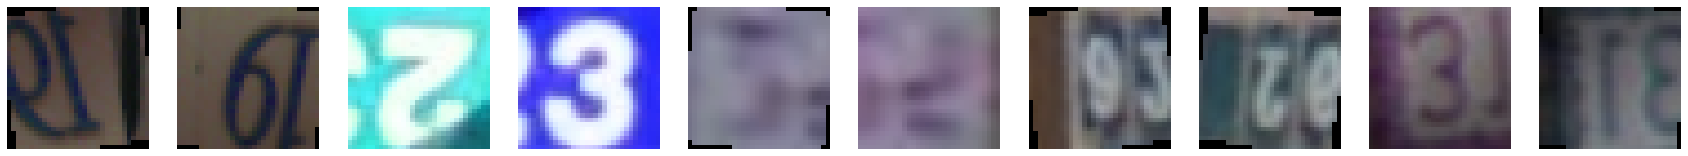

In [15]:
# TODO: Visualize some augmented images!
# hint: you can create new datasets and loaders to accomplish this

# Based on the visualizations, should we keep all the augmentations?

tfs = transforms.Compose([
    transforms.ColorJitter(hue=.20, saturation=.20),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(10, resample=PIL.Image.BILINEAR),
])

data_aug_vis = dset.SVHN('./', 
                       transform=tfs
                      )

plt.figure(figsize=(30, 3))

for i, (x, y) in enumerate(data_aug_vis):
    if i == 10:
        break
    plt.subplot(1, 10, i+1)
    plt.grid(False)
    plt.imshow(x)
    plt.axis('off')

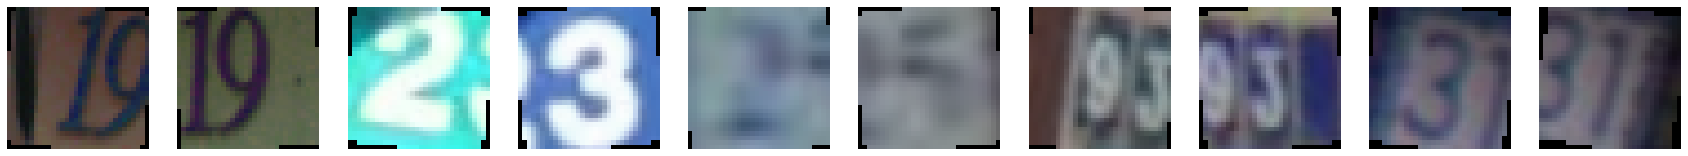

In [17]:
# TODO: Visualize some augmented images!
# hint: you can create new datasets and loaders to accomplish this

# Based on the visualizations, should we keep all the augmentations?

tfs = transforms.Compose([
    transforms.ColorJitter(hue=.10, saturation=.5),
    transforms.RandomRotation(10, resample=PIL.Image.BILINEAR),
])

data_aug_vis = dset.SVHN('./', 
                       transform=tfs
                      )

plt.figure(figsize=(30, 3))

for i, (x, y) in enumerate(data_aug_vis):
    if i == 10:
        break
    plt.subplot(1, 10, i+1)
    plt.grid(False)
    plt.imshow(x)
    plt.axis('off')

In [19]:
nn_model = nn.Sequential(
            nn.Conv2d(3, 64, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(4),
            nn.Conv2d(64, 64, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(4),    
            Flattener(),
            nn.Linear(64*2*2, 10),
          )

nn_model.type(torch.cuda.FloatTensor)
nn_model.to(device)

loss = nn.CrossEntropyLoss().type(torch.cuda.FloatTensor)
optimizer = optim.SGD(nn_model.parameters(), lr=1e-1, weight_decay=1e-4)

# TODO: 
tfs = transforms.Compose([
    # TODO: Add good augmentations
    transforms.ColorJitter(hue=.10, saturation=.5),
    transforms.RandomRotation(10, resample=PIL.Image.BILINEAR),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.43,0.44,0.47],
                       std=[0.20,0.20,0.20])                           
])

# TODO create new instances of loaders with the augmentations you chose
data_aug_train = dset.SVHN('./', transform=tfs)

train_aug_loader = torch.utils.data.DataLoader(data_aug_train, batch_size=batch_size, 
                                           sampler=train_sampler)

# Finally, let's train with augmentations!

# Note we shouldn't use augmentations on validation

loss_history, train_history, val_history = train_model(nn_model, train_aug_loader, val_loader, loss, optimizer, 5)

Epoch: 0, Average loss: 1.601525, Train accuracy: 0.456045, Val accuracy: 0.711965
Epoch: 1, Average loss: 0.812640, Train accuracy: 0.746886, Val accuracy: 0.773463
Epoch: 2, Average loss: 0.700375, Train accuracy: 0.783708, Val accuracy: 0.800218
Epoch: 3, Average loss: 0.634848, Train accuracy: 0.806539, Val accuracy: 0.826770
Epoch: 4, Average loss: 0.596509, Train accuracy: 0.817305, Val accuracy: 0.819398


#LeNet

In [0]:
lenet_model = nn.Sequential(
            nn.Conv2d(3, 6, 5, padding=0),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
            nn.Conv2d(6, 16, 5, padding=0),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
            Flattener(),
            nn.Linear(16*5*5, 120),
            nn.ReLU(inplace=True),
            nn.Linear(120, 84),
            nn.ReLU(inplace=True),
            nn.Linear(84, 10),
          )

lenet_model.type(torch.cuda.FloatTensor)
lenet_model.to(device)

loss = nn.CrossEntropyLoss().type(torch.cuda.FloatTensor)
optimizer = optim.SGD(lenet_model.parameters(), lr=1e-1, weight_decay=1e-4)

In [21]:
loss_history, train_history, val_history = train_model(lenet_model, train_loader, val_loader, loss, optimizer, 5)

Epoch: 0, Average loss: 1.417868, Train accuracy: 0.516193, Val accuracy: 0.806907
Epoch: 1, Average loss: 0.527632, Train accuracy: 0.844026, Val accuracy: 0.847451
Epoch: 2, Average loss: 0.422097, Train accuracy: 0.876310, Val accuracy: 0.871203
Epoch: 3, Average loss: 0.371808, Train accuracy: 0.889909, Val accuracy: 0.867245
Epoch: 4, Average loss: 0.332813, Train accuracy: 0.901734, Val accuracy: 0.883148


# Подбор гиперпараметров


In [60]:
# The key hyperparameters we're going to tune are learning speed, annealing rate and regularization
# We also encourage you to try different optimizers as well

Hyperparams = namedtuple("Hyperparams", ['learning_rate', 'anneal_epochs', 'reg'])
RunResult = namedtuple("RunResult", ['model', 'train_history', 'val_history', 'final_val_accuracy'])

#learning_rates = [1e0, 1e-1, 1e-2, 1e-3, 1e-4]
learning_rates = [5e-1, 1e-1, 5e-2, 1e-2, 1e-3]
#anneal_coeff = 0.2
anneal_coeff = 0.3
#anneal_epochs = [1, 5, 10, 15, 20, 50]
anneal_epochs = [1, 3, 5, 7, 10]
#reg = [1e-3, 1e-4, 1e-5, 1e-7]
reg = [1e-2, 1e-3, 1e-4, 1e-5]

batch_size = 64
epoch_num = 10

# Record all the runs here
# Key should be Hyperparams and values should be RunResult
run_record = {} 

# Use grid search or random search and record all runs in run_record dictionnary 
# Important: perform search in logarithmic space!
# TODO: Your code here!

# logspace_learning_rates = np.logspace( np.log10(min(learning_rates)), np.log10(max(learning_rates)), num=len(learning_rates) )
# logspace_anneal_epochs = np.logspace( np.log10(min(anneal_epochs)), np.log10(max(anneal_epochs)), num=len(anneal_epochs) )
# logspace_reg = np.logspace( np.log10(min(reg)), np.log10(max(reg)), num=len(reg) )

params = []
params.append(learning_rates)
params.append(anneal_epochs)
params.append(reg)
params = [list(x) for x in np.array(np.meshgrid(*params)).T.reshape(-1,len(params))]

hyperparams = []
for param in params:
    hyperparams.append(Hyperparams(*param))
np.random.shuffle(hyperparams)

iter_num = 10
for i in range(iter_num):
    print(hyperparams[i])

    train_loader = torch.utils.data.DataLoader(data_train, batch_size=batch_size, 
                                              sampler=train_sampler)
    val_loader = torch.utils.data.DataLoader(data_train, batch_size=batch_size,
                                            sampler=val_sampler)

    lenet_model = nn.Sequential(
                nn.Conv2d(3, 6, 5, padding=0),
                nn.ReLU(inplace=True),
                nn.MaxPool2d(2),
                nn.Conv2d(6, 16, 5, padding=0),
                nn.ReLU(inplace=True),
                nn.MaxPool2d(2),
                Flattener(),
                nn.Linear(16*5*5, 120),
                nn.ReLU(inplace=True),
                nn.Linear(120, 84),
                nn.ReLU(inplace=True),
                nn.Linear(84, 10),
              )

    lenet_model.type(torch.cuda.FloatTensor)
    lenet_model.to(device)

    loss = nn.CrossEntropyLoss().type(torch.cuda.FloatTensor)
    optimizer = optim.SGD(lenet_model.parameters(), lr=hyperparams[i].learning_rate, weight_decay=hyperparams[i].reg)
    scheduler = optim.lr_scheduler.StepLR(optimizer, hyperparams[i].anneal_epochs, anneal_coeff)
    loss_history, train_history, val_history = train_model(lenet_model, train_loader, val_loader, loss, optimizer, epoch_num, scheduler=scheduler)

    run_record[hyperparams[i]] = RunResult(lenet_model, train_history, val_history, val_history[-1])

Hyperparams(learning_rate=0.1, anneal_epochs=3.0, reg=0.001)
Epoch: 0, Average loss: 1.169135, Train accuracy: 0.609511, Val accuracy: 0.820081
Epoch: 1, Average loss: 0.488606, Train accuracy: 0.856414, Val accuracy: 0.863968
Epoch: 2, Average loss: 0.403348, Train accuracy: 0.881002, Val accuracy: 0.851409
Epoch: 3, Average loss: 0.291583, Train accuracy: 0.915435, Val accuracy: 0.895707
Epoch: 4, Average loss: 0.266158, Train accuracy: 0.922687, Val accuracy: 0.895229
Epoch: 5, Average loss: 0.250070, Train accuracy: 0.927448, Val accuracy: 0.898437
Epoch: 6, Average loss: 0.214460, Train accuracy: 0.939836, Val accuracy: 0.901372
Epoch: 7, Average loss: 0.206025, Train accuracy: 0.942395, Val accuracy: 0.903147
Epoch: 8, Average loss: 0.200000, Train accuracy: 0.943948, Val accuracy: 0.902532
Epoch: 9, Average loss: 0.188111, Train accuracy: 0.947992, Val accuracy: 0.904989
Hyperparams(learning_rate=0.1, anneal_epochs=5.0, reg=0.01)
Epoch: 0, Average loss: 1.562086, Train accuracy:

In [55]:
best_val_accuracy = None
best_hyperparams = None
best_run = None

for hyperparams, run_result in run_record.items():
    if best_val_accuracy is None or best_val_accuracy < run_result.final_val_accuracy:
        best_val_accuracy = run_result.final_val_accuracy
        best_hyperparams = hyperparams
        best_run = run_result
        
print("Best validation accuracy: %4.2f, best hyperparams: %s" % (best_val_accuracy, best_hyperparams))

Best validation accuracy: 0.90, best hyperparams: Hyperparams(learning_rate=0.1, anneal_epochs=5.0, reg=0.001)


#Свободное упражнение - догоним и перегоним LeNet!
# Финальный аккорд - проверим лучшую модель на test set

73257 146514


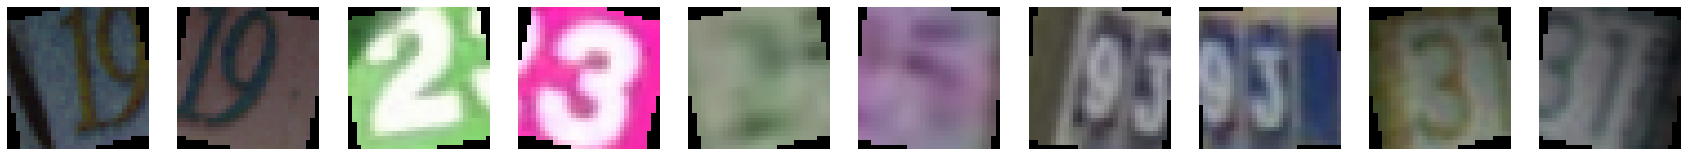

In [79]:
tfs = transforms.Compose([
    transforms.ColorJitter(hue=.5, saturation=.5),  
    transforms.RandomRotation(15, resample=PIL.Image.BILINEAR),
])


data_aug_vis = torch.utils.data.ConcatDataset(
        [dset.SVHN('./', transform=tfs),
         dset.SVHN('./', transform=tfs)
         ])

plt.figure(figsize=(30, 3))

print(len(data_train), len(data_aug_vis))

for i, (x, y) in enumerate(data_aug_vis):
    if i == 10:
        break
    plt.subplot(1, 10, i+1)
    plt.grid(False)
    plt.imshow(x)
    plt.axis('off')

#test 1

Epoch: 0, Average loss: 0.907857, Train accuracy: 0.703820, Val accuracy: 0.865743
Epoch: 1, Average loss: 0.427387, Train accuracy: 0.872996, Val accuracy: 0.892772
Epoch: 2, Average loss: 0.359854, Train accuracy: 0.892934, Val accuracy: 0.902805
Epoch: 3, Average loss: 0.260940, Train accuracy: 0.923766, Val accuracy: 0.920756
Epoch: 4, Average loss: 0.236688, Train accuracy: 0.930728, Val accuracy: 0.922121
Epoch: 5, Average loss: 0.225161, Train accuracy: 0.933886, Val accuracy: 0.928128
Test accuracy: 0.9061


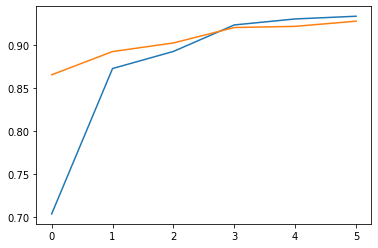

In [91]:
lr = 1e-1
l2 = 1e-3
anneal_coeff = 0.3
anneal_epochs = 3
batch_size = 64
epoch_num = 6
validation_split = .2
augment_part = .3

nn_model = nn.Sequential(
            nn.Conv2d(3, 6, 5, padding=0),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
            nn.Conv2d(6, 16, 5, padding=0),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
            Flattener(),
            nn.Linear(16*5*5, 120),
            nn.ReLU(inplace=True),
            nn.Linear(120, 84),
            nn.ReLU(inplace=True),
            nn.Linear(84, 10),
          )
nn_model.type(torch.cuda.FloatTensor)
nn_model.to(device)

tfs = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.43,0.44,0.47],
                       std=[0.20,0.20,0.20])                           
])

tfs_augment = transforms.Compose([
    transforms.ColorJitter(hue=.10, saturation=.5),
    transforms.RandomRotation(10, resample=PIL.Image.BILINEAR),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.43,0.44,0.47],
                       std=[0.20,0.20,0.20])                           
])

data_train = dset.SVHN('./', split='train', transform=tfs)
data_augment = dset.SVHN('./', split='train', transform=tfs_augment)
data_test = dset.SVHN('./', split='test', transform=tfs)

data_size = data_train.data.shape[0]
valid_size = int(data_size * validation_split)
train_size = data_size - valid_size
data_train, data_valid = torch.utils.data.random_split(data_train, (train_size, valid_size))
loader_valid = torch.utils.data.DataLoader(data_valid, batch_size=batch_size)

augment_size = data_augment.data.shape[0]
drop_aug_size = int(augment_size * augment_part)
train_aug_size = augment_size - drop_aug_size
data_augment, _ = torch.utils.data.random_split(data_augment, (train_aug_size, drop_aug_size))
data_train_plus_aug = torch.utils.data.ConcatDataset([
          data_train,
          data_augment
          ])
loader_train = torch.utils.data.DataLoader(data_train_plus_aug, batch_size=batch_size, shuffle=True)

loader_test = torch.utils.data.DataLoader(data_test, batch_size=batch_size)


loss = nn.CrossEntropyLoss().type(torch.cuda.FloatTensor)
optimizer = optim.SGD(nn_model.parameters(), lr=lr, weight_decay=l2)
scheduler = optim.lr_scheduler.StepLR(optimizer, anneal_epochs, anneal_coeff)
loss_history, train_history, val_history = train_model(nn_model, loader_train, loader_valid, loss, optimizer, epoch_num, scheduler=scheduler)

test_accuracy = compute_accuracy(nn_model, loader_test)
print("Test accuracy: %2.4f" % test_accuracy)
plt.plot(train_history)
plt.plot(val_history);

#test 2

Epoch: 0, Average loss: 0.614393, Train accuracy: 0.809848, Val accuracy: 0.876937
Epoch: 1, Average loss: 0.382457, Train accuracy: 0.883525, Val accuracy: 0.903693
Epoch: 2, Average loss: 0.319889, Train accuracy: 0.902999, Val accuracy: 0.912907
Epoch: 3, Average loss: 0.272656, Train accuracy: 0.918152, Val accuracy: 0.921234
Epoch: 4, Average loss: 0.233655, Train accuracy: 0.930992, Val accuracy: 0.933520
Epoch: 5, Average loss: 0.205418, Train accuracy: 0.940147, Val accuracy: 0.936387
Test accuracy: 0.9112


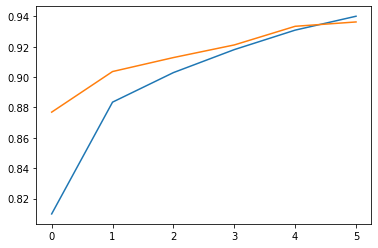

In [100]:
lr = 1e-1
l2 = 1e-3
anneal_coeff = 0.3
anneal_epochs = 3
batch_size = 64
epoch_num = 6
validation_split = .2
augment_part = .3

nn_model = nn.Sequential(
            nn.Conv2d(3, 12, 5, padding=0),
            nn.BatchNorm2d(12),
            nn.LeakyReLU(inplace=True),
            nn.MaxPool2d(2),

            nn.Conv2d(12, 32, 5, padding=0),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(inplace=True),
            nn.MaxPool2d(2),

            Flattener(),
            nn.Linear(32*5*5, 120),
            nn.BatchNorm1d(120),
            nn.LeakyReLU(inplace=True),

            nn.Linear(120, 84),
            nn.BatchNorm1d(84),
            nn.LeakyReLU(inplace=True),

            nn.Linear(84, 10),
          )
nn_model.type(torch.cuda.FloatTensor)
nn_model.to(device)

def init_normal(m):
    if type(m) == nn.Linear or type(m) == nn.Conv2d:
        nn.init.kaiming_normal_(m.weight, nonlinearity='leaky_relu')
nn_model.apply(init_normal)

tfs = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.43,0.44,0.47],
                       std=[0.20,0.20,0.20])                           
])

tfs_augment = transforms.Compose([
    transforms.ColorJitter(hue=.10, saturation=.5),
    transforms.RandomRotation(10, resample=PIL.Image.BILINEAR),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.43,0.44,0.47],
                       std=[0.20,0.20,0.20])                           
])

data_train = dset.SVHN('./', split='train', transform=tfs)
data_augment = dset.SVHN('./', split='train', transform=tfs_augment)
data_test = dset.SVHN('./', split='test', transform=tfs)

data_size = data_train.data.shape[0]
valid_size = int(data_size * validation_split)
train_size = data_size - valid_size
data_train, data_valid = torch.utils.data.random_split(data_train, (train_size, valid_size))
loader_valid = torch.utils.data.DataLoader(data_valid, batch_size=batch_size)

augment_size = data_augment.data.shape[0]
drop_aug_size = int(augment_size * augment_part)
train_aug_size = augment_size - drop_aug_size
data_augment, _ = torch.utils.data.random_split(data_augment, (train_aug_size, drop_aug_size))
data_train_plus_aug = torch.utils.data.ConcatDataset([
          data_train,
          data_augment
          ])
loader_train = torch.utils.data.DataLoader(data_train_plus_aug, batch_size=batch_size, shuffle=True)

loader_test = torch.utils.data.DataLoader(data_test, batch_size=batch_size)


loss = nn.CrossEntropyLoss().type(torch.cuda.FloatTensor)
optimizer = optim.SGD(nn_model.parameters(), lr=lr, weight_decay=l2)
#optimizer = optim.Adam(nn_model.parameters(), lr=lr, weight_decay=l2)
#scheduler = optim.lr_scheduler.StepLR(optimizer, anneal_epochs, anneal_coeff)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, epoch_num, eta_min=0)
loss_history, train_history, val_history = train_model(nn_model, loader_train, loader_valid, loss, optimizer, epoch_num, scheduler=scheduler)

test_accuracy = compute_accuracy(nn_model, loader_test)
print("Test accuracy: %2.4f" % test_accuracy)
plt.plot(train_history)
plt.plot(val_history);

#test 3

Epoch: 0, Average loss: 0.552403, Train accuracy: 0.828750, Val accuracy: 0.896594
Epoch: 1, Average loss: 0.323012, Train accuracy: 0.902453, Val accuracy: 0.923964
Epoch: 2, Average loss: 0.250751, Train accuracy: 0.924121, Val accuracy: 0.934134
Epoch: 3, Average loss: 0.192586, Train accuracy: 0.942768, Val accuracy: 0.946079
Epoch: 4, Average loss: 0.138444, Train accuracy: 0.960596, Val accuracy: 0.957819
Epoch: 5, Average loss: 0.104157, Train accuracy: 0.971652, Val accuracy: 0.963688
Test accuracy: 0.9204


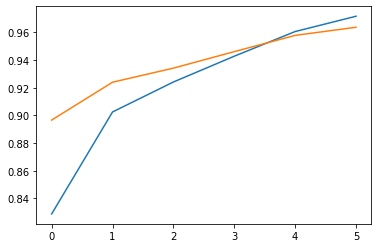

In [101]:
lr = 1e-1
l2 = 1e-3
anneal_coeff = 0.3
anneal_epochs = 3
batch_size = 64
epoch_num = 6
validation_split = .2
augment_part = .3

nn_model = nn.Sequential(
            nn.Conv2d(3, 24, 5, padding=0),
            nn.BatchNorm2d(24),
            nn.LeakyReLU(inplace=True),
            nn.MaxPool2d(2),

            nn.Conv2d(24, 64, 5, padding=0),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(inplace=True),
            nn.MaxPool2d(2),

            Flattener(),
            nn.Linear(64*5*5, 450),
            nn.BatchNorm1d(450),
            nn.LeakyReLU(inplace=True),

            nn.Linear(450, 240),
            nn.BatchNorm1d(240),
            nn.LeakyReLU(inplace=True),

            nn.Linear(240, 84),
            nn.BatchNorm1d(84),
            nn.LeakyReLU(inplace=True),

            nn.Linear(84, 10),
          )
nn_model.type(torch.cuda.FloatTensor)
nn_model.to(device)

def init_normal(m):
    if type(m) == nn.Linear or type(m) == nn.Conv2d:
        nn.init.kaiming_normal_(m.weight, nonlinearity='leaky_relu')
nn_model.apply(init_normal)

tfs = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.43,0.44,0.47],
                       std=[0.20,0.20,0.20])                           
])

tfs_augment = transforms.Compose([
    transforms.ColorJitter(hue=.10, saturation=.5),
    transforms.RandomRotation(10, resample=PIL.Image.BILINEAR),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.43,0.44,0.47],
                       std=[0.20,0.20,0.20])                           
])

data_train = dset.SVHN('./', split='train', transform=tfs)
data_augment = dset.SVHN('./', split='train', transform=tfs_augment)
data_test = dset.SVHN('./', split='test', transform=tfs)

data_size = data_train.data.shape[0]
valid_size = int(data_size * validation_split)
train_size = data_size - valid_size
data_train, data_valid = torch.utils.data.random_split(data_train, (train_size, valid_size))
loader_valid = torch.utils.data.DataLoader(data_valid, batch_size=batch_size)

augment_size = data_augment.data.shape[0]
drop_aug_size = int(augment_size * augment_part)
train_aug_size = augment_size - drop_aug_size
data_augment, _ = torch.utils.data.random_split(data_augment, (train_aug_size, drop_aug_size))
data_train_plus_aug = torch.utils.data.ConcatDataset([
          data_train,
          data_augment
          ])
loader_train = torch.utils.data.DataLoader(data_train_plus_aug, batch_size=batch_size, shuffle=True)

loader_test = torch.utils.data.DataLoader(data_test, batch_size=batch_size)


loss = nn.CrossEntropyLoss().type(torch.cuda.FloatTensor)
optimizer = optim.SGD(nn_model.parameters(), lr=lr, weight_decay=l2)
#optimizer = optim.Adam(nn_model.parameters(), lr=lr, weight_decay=l2)
#scheduler = optim.lr_scheduler.StepLR(optimizer, anneal_epochs, anneal_coeff)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, epoch_num, eta_min=0)
loss_history, train_history, val_history = train_model(nn_model, loader_train, loader_valid, loss, optimizer, epoch_num, scheduler=scheduler)

test_accuracy = compute_accuracy(nn_model, loader_test)
print("Test accuracy: %2.4f" % test_accuracy)
plt.plot(train_history)
plt.plot(val_history);

#test 4

Epoch: 0, Average loss: 0.620999, Train accuracy: 0.801958, Val accuracy: 0.888881
Epoch: 1, Average loss: 0.341344, Train accuracy: 0.896220, Val accuracy: 0.913316
Epoch: 2, Average loss: 0.262728, Train accuracy: 0.920836, Val accuracy: 0.932223
Epoch: 3, Average loss: 0.195399, Train accuracy: 0.941421, Val accuracy: 0.944509
Epoch: 4, Average loss: 0.123926, Train accuracy: 0.962880, Val accuracy: 0.955976
Epoch: 5, Average loss: 0.077674, Train accuracy: 0.976612, Val accuracy: 0.963552
Test accuracy: 0.9253


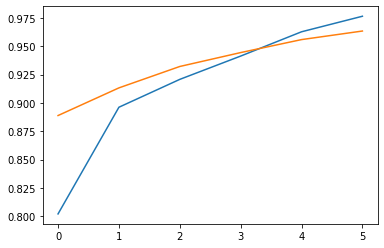

In [103]:
lr = 1e-2
l2 = 1e-6
anneal_coeff = 0.3
anneal_epochs = 3
batch_size = 64
epoch_num = 6
validation_split = .2
augment_part = .3

nn_model = nn.Sequential(
            nn.Conv2d(3, 24, 5, padding=0),
            nn.BatchNorm2d(24),
            nn.LeakyReLU(inplace=True),
            nn.MaxPool2d(2),

            nn.Conv2d(24, 64, 5, padding=0),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(inplace=True),
            nn.MaxPool2d(2),

            Flattener(),
            nn.Linear(64*5*5, 450),
            nn.BatchNorm1d(450),
            nn.LeakyReLU(inplace=True),

            nn.Linear(450, 240),
            nn.BatchNorm1d(240),
            nn.LeakyReLU(inplace=True),

            nn.Linear(240, 84),
            nn.BatchNorm1d(84),
            nn.LeakyReLU(inplace=True),

            nn.Linear(84, 10),
          )
nn_model.type(torch.cuda.FloatTensor)
nn_model.to(device)

def init_normal(m):
    if type(m) == nn.Linear or type(m) == nn.Conv2d:
        nn.init.kaiming_normal_(m.weight, nonlinearity='leaky_relu')
nn_model.apply(init_normal)

tfs = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.43,0.44,0.47],
                       std=[0.20,0.20,0.20])                           
])

tfs_augment = transforms.Compose([
    transforms.ColorJitter(hue=.10, saturation=.5),
    transforms.RandomRotation(10, resample=PIL.Image.BILINEAR),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.43,0.44,0.47],
                       std=[0.20,0.20,0.20])                           
])

data_train = dset.SVHN('./', split='train', transform=tfs)
data_augment = dset.SVHN('./', split='train', transform=tfs_augment)
data_test = dset.SVHN('./', split='test', transform=tfs)

data_size = data_train.data.shape[0]
valid_size = int(data_size * validation_split)
train_size = data_size - valid_size
data_train, data_valid = torch.utils.data.random_split(data_train, (train_size, valid_size))
loader_valid = torch.utils.data.DataLoader(data_valid, batch_size=batch_size)

augment_size = data_augment.data.shape[0]
drop_aug_size = int(augment_size * augment_part)
train_aug_size = augment_size - drop_aug_size
data_augment, _ = torch.utils.data.random_split(data_augment, (train_aug_size, drop_aug_size))
data_train_plus_aug = torch.utils.data.ConcatDataset([
          data_train,
          data_augment
          ])
loader_train = torch.utils.data.DataLoader(data_train_plus_aug, batch_size=batch_size, shuffle=True)

loader_test = torch.utils.data.DataLoader(data_test, batch_size=batch_size)


loss = nn.CrossEntropyLoss().type(torch.cuda.FloatTensor)
#optimizer = optim.SGD(nn_model.parameters(), lr=lr, weight_decay=l2)
optimizer = optim.Adam(nn_model.parameters(), lr=lr, weight_decay=l2)
#scheduler = optim.lr_scheduler.StepLR(optimizer, anneal_epochs, anneal_coeff)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, epoch_num, eta_min=0)
loss_history, train_history, val_history = train_model(nn_model, loader_train, loader_valid, loss, optimizer, epoch_num, scheduler=scheduler)

test_accuracy = compute_accuracy(nn_model, loader_test)
print("Test accuracy: %2.4f" % test_accuracy)
plt.plot(train_history)
plt.plot(val_history);

#test 5

Epoch: 0, Average loss: 0.579743, Train accuracy: 0.819131, Val accuracy: 0.882807
Epoch: 1, Average loss: 0.332303, Train accuracy: 0.898549, Val accuracy: 0.906013
Epoch: 2, Average loss: 0.274324, Train accuracy: 0.917178, Val accuracy: 0.907037
Epoch: 3, Average loss: 0.219893, Train accuracy: 0.934377, Val accuracy: 0.928196
Epoch: 4, Average loss: 0.145212, Train accuracy: 0.957574, Val accuracy: 0.949150
Epoch: 5, Average loss: 0.081597, Train accuracy: 0.977631, Val accuracy: 0.965873
Test accuracy: 0.9301


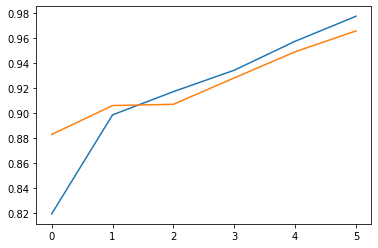

In [114]:
lr = 1e-2
l2 = 1e-4
anneal_coeff = 0.3
anneal_epochs = 3
batch_size = 512
epoch_num = 6
validation_split = .2
augment_part = .3

nn_model = nn.Sequential(
            nn.Conv2d(3, 24, 5, padding=0),
            nn.BatchNorm2d(24),
            nn.LeakyReLU(inplace=True),
            nn.MaxPool2d(2),

            nn.Conv2d(24, 64, 5, padding=0),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(inplace=True),
            nn.MaxPool2d(2),

            Flattener(),
            nn.Linear(64*5*5, 450),
            nn.BatchNorm1d(450),
            nn.LeakyReLU(inplace=True),

            nn.Linear(450, 240),
            nn.BatchNorm1d(240),
            nn.LeakyReLU(inplace=True),

            nn.Linear(240, 84),
            nn.BatchNorm1d(84),
            nn.LeakyReLU(inplace=True),

            nn.Linear(84, 10),
          )
nn_model.type(torch.cuda.FloatTensor)
nn_model.to(device)

def init_normal(m):
    if type(m) == nn.Linear or type(m) == nn.Conv2d:
        nn.init.kaiming_normal_(m.weight, nonlinearity='leaky_relu')
nn_model.apply(init_normal)

tfs = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.43,0.44,0.47],
                       std=[0.20,0.20,0.20])                           
])

tfs_augment = transforms.Compose([
    transforms.ColorJitter(hue=.10, saturation=.5),
    transforms.RandomRotation(10, resample=PIL.Image.BILINEAR),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.43,0.44,0.47],
                       std=[0.20,0.20,0.20])                           
])

data_train = dset.SVHN('./', split='train', transform=tfs)
data_augment = dset.SVHN('./', split='train', transform=tfs_augment)
data_test = dset.SVHN('./', split='test', transform=tfs)

data_size = data_train.data.shape[0]
valid_size = int(data_size * validation_split)
train_size = data_size - valid_size
data_train, data_valid = torch.utils.data.random_split(data_train, (train_size, valid_size))
loader_valid = torch.utils.data.DataLoader(data_valid, batch_size=batch_size)

augment_size = data_augment.data.shape[0]
drop_aug_size = int(augment_size * augment_part)
train_aug_size = augment_size - drop_aug_size
data_augment, _ = torch.utils.data.random_split(data_augment, (train_aug_size, drop_aug_size))
data_train_plus_aug = torch.utils.data.ConcatDataset([
          data_train,
          data_augment
          ])
loader_train = torch.utils.data.DataLoader(data_train_plus_aug, batch_size=batch_size, shuffle=True)

loader_test = torch.utils.data.DataLoader(data_test, batch_size=batch_size)


loss = nn.CrossEntropyLoss().type(torch.cuda.FloatTensor)
#optimizer = optim.SGD(nn_model.parameters(), lr=lr, weight_decay=l2)
optimizer = optim.Adam(nn_model.parameters(), lr=lr, weight_decay=l2)
#scheduler = optim.lr_scheduler.StepLR(optimizer, anneal_epochs, anneal_coeff)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, epoch_num, eta_min=0)
loss_history, train_history, val_history = train_model(nn_model, loader_train, loader_valid, loss, optimizer, epoch_num, scheduler=scheduler)

test_accuracy = compute_accuracy(nn_model, loader_test)
print("Test accuracy: %2.4f" % test_accuracy)
plt.plot(train_history)
plt.plot(val_history);

#test 6

Epoch: 0, Average loss: 0.800368, Train accuracy: 0.739803, Val accuracy: 0.899324
Epoch: 1, Average loss: 0.303619, Train accuracy: 0.906803, Val accuracy: 0.915842
Epoch: 2, Average loss: 0.242727, Train accuracy: 0.928426, Val accuracy: 0.922736
Epoch: 3, Average loss: 0.189937, Train accuracy: 0.944033, Val accuracy: 0.934953
Epoch: 4, Average loss: 0.121711, Train accuracy: 0.965046, Val accuracy: 0.948672
Epoch: 5, Average loss: 0.064370, Train accuracy: 0.982491, Val accuracy: 0.968739
Test accuracy: 0.9389


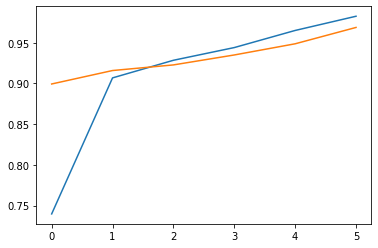

In [117]:
lr = 1e-2
l2 = 1e-4
anneal_coeff = 0.3
anneal_epochs = 3
batch_size = 512
epoch_num = 6
validation_split = .2
augment_part = .3

nn_model = nn.Sequential(
            nn.Conv2d(3, 24, 3, padding=1), # 32 -> 32
            nn.MaxPool2d(2),
            nn.LeakyReLU(inplace=True),
            nn.BatchNorm2d(24), # 32 -> 16

            nn.Conv2d(24, 64, 3, padding=1), # 16 -> 16
            nn.MaxPool2d(2),
            nn.LeakyReLU(inplace=True),
            nn.BatchNorm2d(64), # 16 -> 8

            nn.Conv2d(64, 128, 3, padding=1), # 8 -> 8
            nn.MaxPool2d(2),
            nn.LeakyReLU(inplace=True),
            nn.BatchNorm2d(128), # 8 -> 4

            Flattener(),
            nn.Linear(128*4*4, 650),
            nn.LeakyReLU(inplace=True),
            nn.BatchNorm1d(650),

            nn.Linear(650, 380),
            nn.LeakyReLU(inplace=True),
            nn.BatchNorm1d(380),

            nn.Linear(380, 120),
            nn.LeakyReLU(inplace=True),
            nn.BatchNorm1d(120),

            nn.Linear(120, 10),
          )
nn_model.type(torch.cuda.FloatTensor)
nn_model.to(device)

def init_normal(m):
    if type(m) == nn.Linear or type(m) == nn.Conv2d:
        nn.init.kaiming_normal_(m.weight, nonlinearity='leaky_relu')
nn_model.apply(init_normal)

tfs = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.43,0.44,0.47],
                       std=[0.20,0.20,0.20])                           
])

tfs_augment = transforms.Compose([
    transforms.ColorJitter(hue=.10, saturation=.5),
    transforms.RandomRotation(10, resample=PIL.Image.BILINEAR),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.43,0.44,0.47],
                       std=[0.20,0.20,0.20])                           
])

data_train = dset.SVHN('./', split='train', transform=tfs)
data_augment = dset.SVHN('./', split='train', transform=tfs_augment)
data_test = dset.SVHN('./', split='test', transform=tfs)

data_size = data_train.data.shape[0]
valid_size = int(data_size * validation_split)
train_size = data_size - valid_size
data_train, data_valid = torch.utils.data.random_split(data_train, (train_size, valid_size))
loader_valid = torch.utils.data.DataLoader(data_valid, batch_size=batch_size)

augment_size = data_augment.data.shape[0]
drop_aug_size = int(augment_size * augment_part)
train_aug_size = augment_size - drop_aug_size
data_augment, _ = torch.utils.data.random_split(data_augment, (train_aug_size, drop_aug_size))
data_train_plus_aug = torch.utils.data.ConcatDataset([
          data_train,
          data_augment
          ])
loader_train = torch.utils.data.DataLoader(data_train_plus_aug, batch_size=batch_size, shuffle=True)

loader_test = torch.utils.data.DataLoader(data_test, batch_size=batch_size)


loss = nn.CrossEntropyLoss().type(torch.cuda.FloatTensor)
#optimizer = optim.SGD(nn_model.parameters(), lr=lr, weight_decay=l2)
optimizer = optim.Adam(nn_model.parameters(), lr=lr, weight_decay=l2)
#scheduler = optim.lr_scheduler.StepLR(optimizer, anneal_epochs, anneal_coeff)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, epoch_num, eta_min=0)
loss_history, train_history, val_history = train_model(nn_model, loader_train, loader_valid, loss, optimizer, epoch_num, scheduler=scheduler)

test_accuracy = compute_accuracy(nn_model, loader_test)
print("Test accuracy: %2.4f" % test_accuracy)
plt.plot(train_history)
plt.plot(val_history);

#test 7

Epoch: 0, Average loss: 0.812784, Train accuracy: 0.735289, Val accuracy: 0.892499
Epoch: 1, Average loss: 0.311723, Train accuracy: 0.905757, Val accuracy: 0.914409
Epoch: 2, Average loss: 0.256629, Train accuracy: 0.922511, Val accuracy: 0.919255
Epoch: 3, Average loss: 0.215785, Train accuracy: 0.936825, Val accuracy: 0.934612
Epoch: 4, Average loss: 0.174768, Train accuracy: 0.948428, Val accuracy: 0.943622
Epoch: 5, Average loss: 0.126281, Train accuracy: 0.962789, Val accuracy: 0.955907
Epoch: 6, Average loss: 0.069511, Train accuracy: 0.980216, Val accuracy: 0.968057
Epoch: 7, Average loss: 0.034965, Train accuracy: 0.990436, Val accuracy: 0.977066
Test accuracy: 0.9413


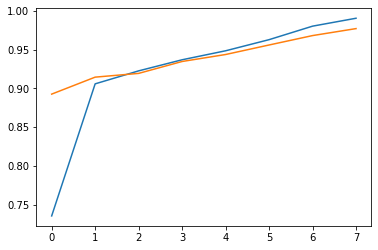

In [121]:
lr = 1e-2
l2 = 1e-4
anneal_coeff = 0.3
anneal_epochs = 3
batch_size = 512
epoch_num = 8
validation_split = .2
augment_part = .3

nn_model = nn.Sequential(
            nn.Conv2d(3, 24, 3, padding=1), # 32 -> 32
            nn.MaxPool2d(2),
            nn.LeakyReLU(inplace=True),
            nn.BatchNorm2d(24), # 32 -> 16

            nn.Conv2d(24, 64, 3, padding=1), # 16 -> 16
            nn.MaxPool2d(2),
            nn.LeakyReLU(inplace=True),
            nn.BatchNorm2d(64), # 16 -> 8

            nn.Conv2d(64, 128, 3, padding=1), # 8 -> 8
            nn.MaxPool2d(2),
            nn.LeakyReLU(inplace=True),
            nn.BatchNorm2d(128), # 8 -> 4

            Flattener(),
            nn.Linear(128*4*4, 650),
            nn.LeakyReLU(inplace=True),
            nn.BatchNorm1d(650),

            nn.Linear(650, 380),
            nn.LeakyReLU(inplace=True),
            nn.BatchNorm1d(380),

            nn.Linear(380, 120),
            nn.LeakyReLU(inplace=True),
            nn.BatchNorm1d(120),

            nn.Linear(120, 10),
          )
nn_model.type(torch.cuda.FloatTensor)
nn_model.to(device)

def init_normal(m):
    if type(m) == nn.Linear or type(m) == nn.Conv2d:
        nn.init.kaiming_normal_(m.weight, nonlinearity='leaky_relu')
nn_model.apply(init_normal)

tfs = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.43,0.44,0.47],
                       std=[0.20,0.20,0.20])                           
])

tfs_augment = transforms.Compose([
    transforms.ColorJitter(hue=.10, saturation=.5),
    transforms.RandomRotation(10, resample=PIL.Image.BILINEAR),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.43,0.44,0.47],
                       std=[0.20,0.20,0.20])                           
])

data_train = dset.SVHN('./', split='train', transform=tfs)
data_augment = dset.SVHN('./', split='train', transform=tfs_augment)
data_test = dset.SVHN('./', split='test', transform=tfs)

data_size = data_train.data.shape[0]
valid_size = int(data_size * validation_split)
train_size = data_size - valid_size
data_train, data_valid = torch.utils.data.random_split(data_train, (train_size, valid_size))
loader_valid = torch.utils.data.DataLoader(data_valid, batch_size=batch_size)

augment_size = data_augment.data.shape[0]
drop_aug_size = int(augment_size * augment_part)
train_aug_size = augment_size - drop_aug_size
data_augment, _ = torch.utils.data.random_split(data_augment, (train_aug_size, drop_aug_size))
data_train_plus_aug = torch.utils.data.ConcatDataset([
          data_train,
          data_augment
          ])
loader_train = torch.utils.data.DataLoader(data_train_plus_aug, batch_size=batch_size, shuffle=True)

loader_test = torch.utils.data.DataLoader(data_test, batch_size=batch_size)


loss = nn.CrossEntropyLoss().type(torch.cuda.FloatTensor)
#optimizer = optim.SGD(nn_model.parameters(), lr=lr, weight_decay=l2)
optimizer = optim.Adam(nn_model.parameters(), lr=lr, weight_decay=l2)
#scheduler = optim.lr_scheduler.StepLR(optimizer, anneal_epochs, anneal_coeff)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, epoch_num, eta_min=0)
loss_history, train_history, val_history = train_model(nn_model, loader_train, loader_valid, loss, optimizer, epoch_num, scheduler=scheduler)

test_accuracy = compute_accuracy(nn_model, loader_test)
print("Test accuracy: %2.4f" % test_accuracy)
plt.plot(train_history)
plt.plot(val_history);